In [1]:
# Install and import necessary libraries
# !pip install torch torchvision matplotlib sklearn

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
# Setup CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [23]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [24]:
# Define the Teacher (ResNet18) and Student (simple CNN) networks
teacher = torchvision.models.resnet18(pretrained=True).to(device)
teacher.fc = nn.Linear(teacher.fc.in_features, 10).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
class StudentNet(nn.Module):
    def __init__(self):
        super(StudentNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

student = StudentNet().to(device)

In [26]:
# Training Teacher
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher.parameters(), lr=0.001, momentum=0.9)

for epoch in range(5):
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = teacher(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [27]:
# Knowledge Distillation
temperature = 3.0
alpha = 0.9

optimizer = optim.SGD(student.parameters(), lr=0.001, momentum=0.9)

for epoch in range(5):
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        teacher_outputs = teacher(inputs)
        student_outputs = student(inputs)

        loss = (1. - alpha) * criterion(student_outputs, labels)
        loss += (alpha * temperature * temperature) * criterion(F.log_softmax(student_outputs/temperature, dim=1),
                                                                F.softmax(teacher_outputs/temperature, dim=1))

        loss.backward()
        optimizer.step()


In [28]:
# Evaluation function
def evaluate(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return all_labels, all_preds


In [29]:
# Evaluate Teacher
teacher_labels, teacher_preds = evaluate(teacher, testloader)

# Evaluate Student
student_labels, student_preds = evaluate(student, testloader)


In [30]:
# Metrics Calculation
def compute_metrics(labels, preds):
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    # AUC requires one-hot encoding or probability scores,
    # skipping for this simple example.
    # For multi-class AUC, consider one-vs-all method
    return accuracy, f1, precision, recall

teacher_metrics = compute_metrics(teacher_labels, teacher_preds)
student_metrics = compute_metrics(student_labels, student_preds)

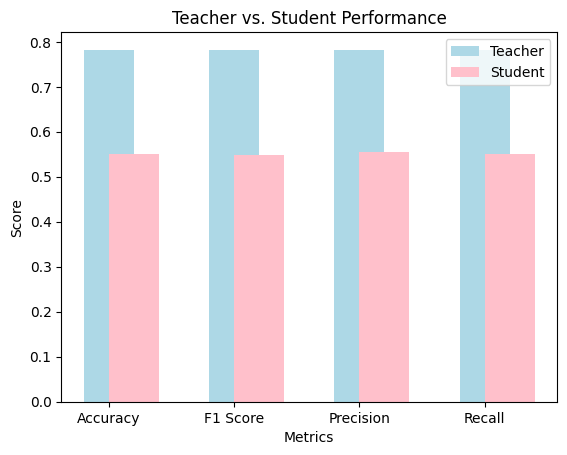

In [31]:
# Visualize results
labels = ["Accuracy", "F1 Score", "Precision", "Recall"]
x = range(len(labels))

plt.bar(x, teacher_metrics, width=0.4, label='Teacher', color='lightblue', align='center')
plt.bar(x, student_metrics, width=0.4, label='Student', color='pink', align='edge')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Teacher vs. Student Performance')
plt.xticks(x, labels)
plt.legend()
plt.show()


## Fine-Tuning


1. We'll introduce data augmentation for the student.
1. Use a learning rate scheduler.
1. Implement early stopping based on validation performance.


This code introduces data augmentation for the student training, a learning rate scheduler that reduces the learning rate if the validation performance plateaus, and an early stopping mechanism to cease training if the validation accuracy doesn't improve for a set number of epochs (defined by patience).

In [32]:
# Setup CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
# Data Augmentation for student training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [34]:
# Teacher and Student definitions from previous code above ^^

In [35]:
# # Training function for early stopping
# def train_student_with_early_stopping(student, teacher, trainloader, valloader, max_epochs=50, patience=5):
#     best_val_acc = 0.0
#     epochs_without_improvement = 0

#     optimizer = optim.Adam(student.parameters(), lr=0.001)
#     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, verbose=True)  # Learning rate scheduler based on validation accuracy

#     for epoch in range(max_epochs):
#         student.train()
#         for inputs, labels in trainloader:
#             inputs, labels = inputs.to(device), labels.to(device)

#             optimizer.zero_grad()

#             teacher_outputs = teacher(inputs)
#             student_outputs = student(inputs)

#             loss = nn.KLDivLoss()(F.log_softmax(student_outputs/temperature, dim=1),
#                                   F.softmax(teacher_outputs/temperature, dim=1))

#             loss.backward()
#             optimizer.step()

#         val_acc = evaluate(student, valloader)
#         print(f"Epoch {epoch+1}, Validation Accuracy: {val_acc*100:.2f}%")

#         # Early Stopping and scheduler step
#         scheduler.step(val_acc)
#         if val_acc > best_val_acc:
#             best_val_acc = val_acc
#             epochs_without_improvement = 0
#         else:
#             epochs_without_improvement += 1
#             if epochs_without_improvement == patience:
#                 print("Early stopping!")
#                 break

# def evaluate(model, dataloader):
#     model.eval()
#     all_labels = []
#     all_preds = []

#     with torch.no_grad():
#         for inputs, labels in dataloader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             _, preds = outputs.max(1)
#             all_labels.extend(labels.cpu().numpy())
#             all_preds.extend(preds.cpu().numpy())

#     return accuracy_score(all_labels, all_preds)

# # Train student with early stopping
# train_student_with_early_stopping(student, teacher, trainloader, valloader)


In [36]:
def evaluate__(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return correct / total  # Ensure scalar value is returned


In [37]:
def train_student_with_early_stopping(student, teacher, trainloader, valloader, max_epochs=50, patience=5):
    best_val_acc = 0.0
    epochs_without_improvement = 0
    train_accuracies = []
    val_accuracies = []
    losses = []

    optimizer = optim.Adam(student.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, verbose=True)

    for epoch in range(max_epochs):
        student.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)

            loss = nn.KLDivLoss()(F.log_softmax(student_outputs/temperature, dim=1),
                                  F.softmax(teacher_outputs/temperature, dim=1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = student_outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = correct / total
        train_accuracies.append(train_acc)
        losses.append(running_loss / len(trainloader))

        val_acc = evaluate__(student, valloader)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}, Train Accuracy: {train_acc*100:.2f}%, Validation Accuracy: {val_acc*100:.2f}%")

        # Early Stopping and scheduler step
        scheduler.step(val_acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement == patience:
                print("Early stopping!")
                break

    return train_accuracies, val_accuracies, losses

train_accuracies, val_accuracies, losses = train_student_with_early_stopping(student, teacher, trainloader, valloader)



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 1, Train Accuracy: 39.42%, Validation Accuracy: 54.17%
Epoch 2, Train Accuracy: 45.22%, Validation Accuracy: 56.37%
Epoch 3, Train Accuracy: 48.30%, Validation Accuracy: 59.62%
Epoch 4, Train Accuracy: 50.55%, Validation Accuracy: 62.25%
Epoch 5, Train Accuracy: 52.21%, Validation Accuracy: 62.82%
Epoch 6, Train Accuracy: 53.47%, Validation Accuracy: 63.14%
Epoch 7, Train Accuracy: 54.30%, Validation Accuracy: 64.68%
Epoch 8, Train Accuracy: 55.40%, Validation Accuracy: 65.07%
Epoch 9, Train Accuracy: 56.03%, Validation Accuracy: 65.72%
Epoch 10, Train Accuracy: 56.66%, Validation Accuracy: 67.06%
Epoch 11, Train Accuracy: 57.14%, Validation Accuracy: 66.91%
Epoch 12, Train Accuracy: 58.25%, Validation Accuracy: 68.24%
Epoch 13, Train Accuracy: 58.14%, Validation Accuracy: 68.06%
Epoch 14, Train Accuracy: 58.57%, Validation Accuracy: 68.55%
Epoch 15, Train Accuracy: 59.19%, Validation Accuracy: 68.81%
Epoch 16, Train Accuracy: 59.45%, Validation Accuracy: 69.39%
Epoch 17, Train A

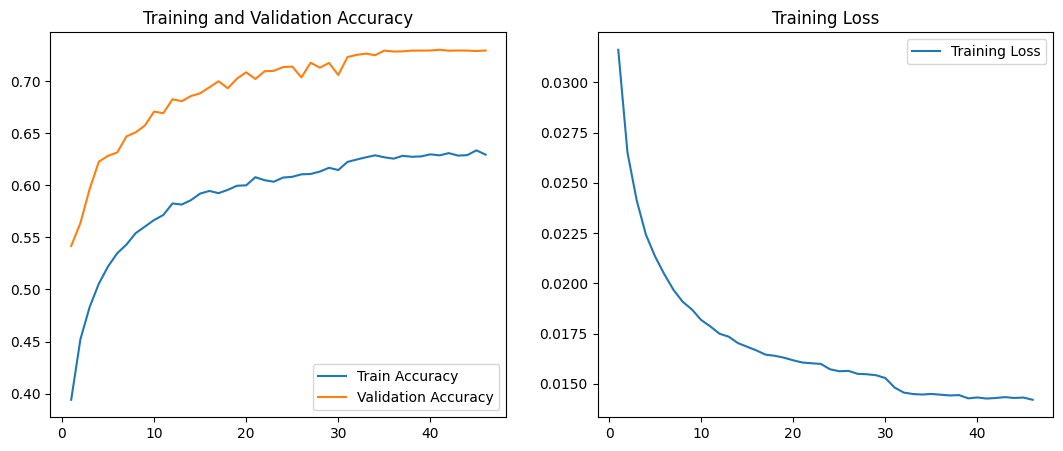

In [38]:
# Visualization
epochs_range = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, losses, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')

plt.show()


In [39]:
# Evaluate Teacher
teacher_labels, teacher_preds = evaluate(teacher, testloader)

# Evaluate Student
student_labels, student_preds = evaluate(student, testloader)


In [40]:
# Metrics Calculation
def compute_metrics(labels, preds):
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    # AUC requires one-hot encoding or probability scores,
    # skipping for this simple example.
    # For multi-class AUC, consider one-vs-all method
    return accuracy, f1, precision, recall

teacher_metrics = compute_metrics(teacher_labels, teacher_preds)
student_metrics = compute_metrics(student_labels, student_preds)

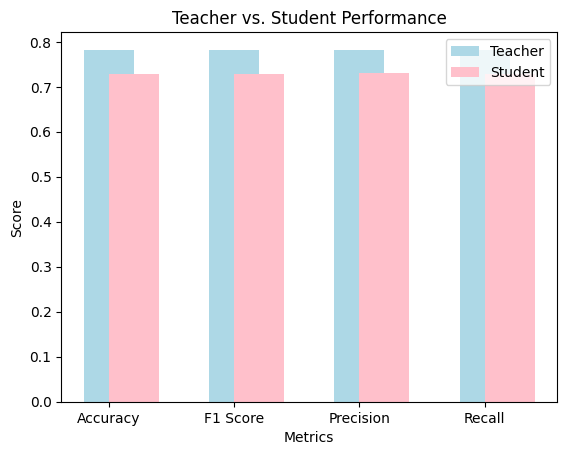

In [41]:
# Visualize results
labels = ["Accuracy", "F1 Score", "Precision", "Recall"]
x = range(len(labels))

plt.bar(x, teacher_metrics, width=0.4, label='Teacher', color='lightblue', align='center')
plt.bar(x, student_metrics, width=0.4, label='Student', color='pink', align='edge')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Teacher vs. Student Performance')
plt.xticks(x, labels)
plt.legend()
plt.show()
